In [1]:
import numpy as np
import math
from scipy.linalg import expm, norm
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate, phase_estimation, RYGate, Measure, QAOAAnsatz, real_amplitudes
import qiskit
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorEstimator as Estimator

# Setup
## Question 1

In [2]:
A = np.array([[5, -1,-2,0], [-1,5,0,-2], [-2,0,5,-1], [0,-2,-1,5]])
A = A / 10
print(A)

b = np.array([1,0,0,0])
print(b)

[[ 0.5 -0.1 -0.2  0. ]
 [-0.1  0.5  0.  -0.2]
 [-0.2  0.   0.5 -0.1]
 [ 0.  -0.2 -0.1  0.5]]
[1 0 0 0]


In [3]:
eigenvalues, eigenvectors = np.linalg.eigh(A)
eigenvectors = eigenvectors.T
print("Eigenvalues:")
for i in range(len(eigenvalues)):
    print(f"λ{i} = {np.round(eigenvalues[i], decimals=2)}")
print("Eigenvectors:")
for i in range(len(eigenvectors)):
    ket = f"|u{i}> = "
    for j in range(len(eigenvectors[i])):
        ket = ket + f"{np.round(eigenvectors[i][j], decimals=2)}|{j}>"
        if j < 3:
            ket = ket + " + "

    print(ket)

Eigenvalues:
λ0 = 0.2
λ1 = 0.4
λ2 = 0.6
λ3 = 0.8
Eigenvectors:
|u0> = 0.5|0> + 0.5|1> + 0.5|2> + 0.5|3>
|u1> = 0.5|0> + -0.5|1> + 0.5|2> + -0.5|3>
|u2> = 0.5|0> + 0.5|1> + -0.5|2> + -0.5|3>
|u3> = -0.5|0> + 0.5|1> + 0.5|2> + -0.5|3>


## Quesion 2

In [4]:
c = [0.5,0.5,0.5,-0.5]
print(f"c values: {c}\n")
b_str = ""
for i in range(len(c)):
    b_str = b_str + f"{c[i]}|u{i}>"
    if i < 3:
            b_str = b_str + " + "
print("|b> = " + b_str)

b_sum = np.round(np.dot(c, eigenvectors))
print(b_sum)

c values: [0.5, 0.5, 0.5, -0.5]

|b> = 0.5|u0> + 0.5|u1> + 0.5|u2> + -0.5|u3>
[ 1.  0. -0.  0.]


## Question 3

In [5]:
# Solve the equation
x = np.round(np.linalg.solve(A, b), decimals=4)
# Normalize the x vector
x_norm = np.linalg.norm(x)
for i in range(len(x)):
    x[i] = x[i] / x_norm

# Prep the list for printing
x_str = ""
for i in range(len(x)):
    x_str = x_str + f"{x[i]}|{i}>"
    if i < 3:
            x_str = x_str + " + "
print(f"|x> = {x_str}")

|x> = 0.8730435931966557|0> + 0.24446025196183138|1> + 0.3841230892729929|2> + 0.1745953088613848|3>


# HHL Implementation

In [6]:
c_qubits = 3
b_qubits = 2
t = 10*np.pi/8
lambda_bars = pow(2,c_qubits) * eigenvalues * t / (2 * np.pi)
thetas = [2 * np.arcsin(1 / round(lambda_bar)) for lambda_bar in lambda_bars]
j = 1j

print(thetas)

A = (1/10) * np.array([[5, -1,-2,0], [-1,5,0,-2], [-2,0,5,-1], [0,-2,-1,5]])
U_mat = expm(1j*A*t)
U = UnitaryGate(U_mat)

[np.float64(3.141592653589793), np.float64(1.0471975511965979), np.float64(0.6796738189082439), np.float64(0.5053605102841573)]


#### The theta values have been calculated, and the unitary gate has been created
#### The qiskit phase_estimation gate will be used for implementing the HHL algorithm

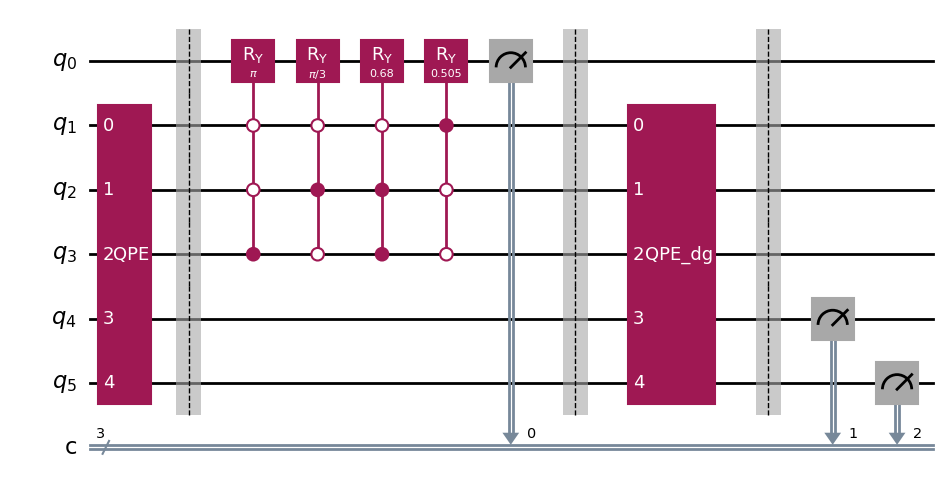

In [7]:
bar = list(range(b_qubits + c_qubits + 1)) # List of qubits for applying QPE and barrier gates

qc = QuantumCircuit(6, 3)

# QPE
qpe = phase_estimation(3, U)
qc.append(qpe, [1,2,3,4,5])
qc.barrier(bar)

# Ry rotations
qc.append(RYGate(thetas[0]).control(3, ctrl_state='001'), [3,2,1,0])
qc.append(RYGate(thetas[1]).control(3, ctrl_state='010'), [3,2,1,0])
qc.append(RYGate(thetas[2]).control(3, ctrl_state='011'), [3,2,1,0])
qc.append(RYGate(thetas[3]).control(3, ctrl_state='100'), [3,2,1,0])
qc.append(Measure(), [0], [0])  # measure qubit 0 into clbit 0
qc.barrier(bar)

# IQPE
qc.append(qpe.inverse(), [1,2,3,4,5])
qc.barrier(bar)

# Measurements
qc.append(Measure(), [4], [1])  # measure qubit 4 into clbit 1
qc.append(Measure(), [5], [2])  # measure qubit 5 into clbit 2
qc.draw('mpl')

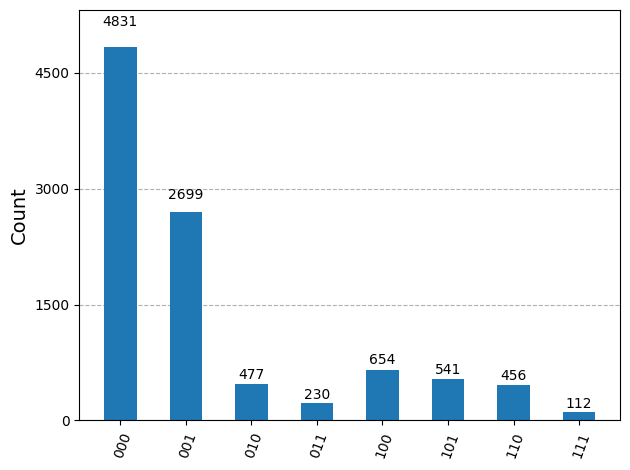

In [8]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
sim_result = simulator.run(compiled_circuit, shots=10000).result()
counts = sim_result.get_counts()

plot_histogram(counts)

In [9]:
x_counts = np.zeros(4)

# Extract the values where a=1
for i in counts:
    index = int(i[:2], 2)
    if i[2] == '1':
        x_counts[index] = counts[i]

# Normalize and print final |x> state
x_norm = np.linalg.norm(x_counts)
for i in range(len(x_counts)):
    x_counts[i] = x_counts[i] / x_norm

# Prep the list for printing
x_str_hhl = ""
for i in range(len(x_counts)):
    x_str_hhl = x_str_hhl + f"{x_counts[i]}|{i}>"
    if i < 3:
            x_str_hhl = x_str_hhl + " + "
print("HHL")
print(f"|x> = {x_str_hhl}")
print("Exact")
print(f"|x> = {x_str}")

HHL
|x> = 0.9762897722136298|0> + 0.08319623846207294|1> + 0.19569202177383244|2> + 0.0405129509032703|3>
Exact
|x> = 0.8730435931966557|0> + 0.24446025196183138|1> + 0.3841230892729929|2> + 0.1745953088613848|3>


#### Small error in the HHL and measurement process lead to measurement values being slightly off. The |0> state being larger than normal caused the probabilities to swing significantly in favour of |0>

# Hybrid Classical–Quantum Approach
## Question 1

### H = A(I-|b><b|)A
### |x> = A^-1|b> / ||A^-1|b>||
### H|x> = A (I-|b><b|) AA^-1 |b>    We will ignore the magnitude on |x> for convenience
### = A (I-|b><b|) |b>

In [10]:
b = np.array([1,0,0,0]) # |b> is in the |0> state
bb = np.zeros((4,4)) # |b><b| has only one 1
bb[0][0] = 1
I = np.identity(4)
bracket = I - bb
print("(I-|b><b|) =")
print(bracket)
bracketb = np.dot(bracket, b)
print("\n(I-|b><b|)|b> =")
print(bracketb)

(I-|b><b|) =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

(I-|b><b|)|b> =
[0. 0. 0. 0.]


### From the above code, we see the expression H|x> will simplify to a 0 vector even before applying the final A gate
## Question 2

In [11]:
H = np.dot(A, np.dot(bracket, A))
print(H)
pauli_H = SparsePauliOp.from_operator(H)
print("\npauli_H =")
print(pauli_H)

[[ 0.05 -0.05 -0.1   0.04]
 [-0.05  0.29  0.02 -0.2 ]
 [-0.1   0.02  0.26 -0.1 ]
 [ 0.04 -0.2  -0.1   0.3 ]]

pauli_H =
SparsePauliOp(['II', 'IX', 'IZ', 'XI', 'XX', 'XZ', 'YY', 'ZI', 'ZX', 'ZZ'],
              coeffs=[ 0.225+0.j, -0.075+0.j, -0.07 +0.j, -0.15 +0.j,  0.03 +0.j,  0.05 +0.j,
 -0.01 +0.j, -0.055+0.j,  0.025+0.j, -0.05 +0.j])


## Question 3
### VQE

In [12]:
# Generate ansatz for VQE
vqe_ansatz = real_amplitudes(num_qubits=2, reps=3)
# Generate the VQE algorithm
vqe = VQE(estimator=Estimator(), optimizer=COBYLA(), ansatz=vqe_ansatz)
# Run VQE using the hamiltonian
result = vqe.compute_minimum_eigenvalue(pauli_H)
# Find the optimal parameters to minimize the system
params = result.optimal_parameters
# Get the ansatz back
circuit = result.optimal_circuit
# Remake the optimal circuit using the parameters
qc = circuit.assign_parameters(params)
# Extract the minimal state
psi = Statevector(qc)
vqe_vals = abs(psi.data)

# Prep the list for printing
vqe_str = ""
for i in range(len(vqe_vals)):
    vqe_str = vqe_str + f"{vqe_vals[i]}|{i}>"
    if i < 3:
            vqe_str = vqe_str + " + "
print("VQE")
print(f"|x> = {vqe_str}")
print("Exact")
print(f"|x> = {x_str}")

VQE
|x> = 0.8729964285545359|0> + 0.24453500531939149|1> + 0.3841601726209966|2> + 0.17464486444289248|3>
Exact
|x> = 0.8730435931966557|0> + 0.24446025196183138|1> + 0.3841230892729929|2> + 0.1745953088613848|3>


### QAOA

In [13]:
cost = SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
                     coeffs = [0.225, -0.07, -0.055, -0.05])
mixer = SparsePauliOp(['IX', 'XI', 'XX', 'XZ', 'YY', 'ZX'],
              coeffs = [-0.075, -0.15,  0.03,  0.05, -0.01,  0.025])

# Generate ansatz for QAOA
qaoa_ansatz = QAOAAnsatz(cost_operator=cost, mixer_operator=mixer, reps=11)
# Generate the QAOA algorithm
qaoa = VQE(estimator=Estimator(), optimizer=COBYLA(), ansatz=qaoa_ansatz)
# Run QAOA using the hamiltonian
result = qaoa.compute_minimum_eigenvalue(pauli_H)
# Find the optimal parameters to minimize the system
params = result.optimal_parameters
# Get the ansatz back
circuit = result.optimal_circuit
# Remake the optimal circuit using the parameters
qc = circuit.assign_parameters(params)
# Extract the minimal state
psi = Statevector(qc)
qaoa_vals = abs(psi.data)

# Prep the list for printing
qaoa_str = ""
for i in range(len(qaoa_vals)):
    qaoa_str = qaoa_str + f"{qaoa_vals[i]}|{i}>"
    if i < 3:
            qaoa_str = qaoa_str + " + "

print("QAOA")
print(f"|x> = {qaoa_str}")
print("Exact")
print(f"|x> = {x_str}")

QAOA
|x> = 0.8730404615998577|0> + 0.24444726975513703|1> + 0.3841339754842409|2> + 0.1746051935007589|3>
Exact
|x> = 0.8730435931966557|0> + 0.24446025196183138|1> + 0.3841230892729929|2> + 0.1745953088613848|3>


#### VQE was able to get nearly the exact state for |x> very easily. QAOA struggled on low reps but converged once the reps hit 11.